### Required libraries

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sys
import numpy as np
import os.path as op
from os import mkdir, makedirs
import scipy.stats as stats
import nipype.interfaces.fsl as fsl
from subprocess import call
import nibabel as nib
from shutil import copyfile
import pandas as pd
import scipy.io as sio
from sklearn import cross_validation
from sklearn import linear_model
from __future__ import division

### Utils

In [37]:
def plot_hist(score,title,xlabel):
    h,b = np.histogram(score, bins='auto')
    plt.hist(score,bins=b)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    return h

### Parameters

In [38]:
behavFile = 'unrestricted_luckydjuju_11_17_2015_0_47_11.csv'
release = 'Q2'
outScore = 'PMAT24_A_CR'
DATADIR = '/media/paola/HCP/'
PARCELDIR = '/home/paola/parcellations'
parcellation = 'shenetal_neuroimage2013'
overwrite = False
thisRun = 'rfMRI_REST1'
isDataClean = True
doPlot = True
useLegendre = True
useCluster = True

if thisRun == 'rfMRI_REST1':
    outMat = 'rest_1_mat'
elif thisRun == 'rfMRI_REST2':
    outMat = 'rest_1_mat'
else:
    sys.exit("Invalid run code")  
    
suffix = '_hp2000_clean' if isDataClean else ''   

def buildpath(subject,fmriRun):
    return op.join(DATADIR, subject,'MNINonLinear','Results',fmriRun)

def testpath(subject,fmriRun):
    return op.join(DATADIR, 'Testing', subject,'Results',fmriRun)

### Functions

In [39]:
def makeTissueMasks(subject,fmriRun,overwrite):
    fmriFile = op.join(buildpath(subject,fmriRun), fmriRun+suffix+'.nii.gz')
    WMmaskFileout = op.join(buildpath(subject,fmriRun), 'WMmask.nii.gz')
    CSFmaskFileout = op.join(buildpath(subject,fmriRun), 'CSFmask.nii.gz')
    GMmaskFileout = op.join(buildpath(subject,fmriRun), 'GMmask.nii.gz')
    WMCSFmaskFileout = op.join(buildpath(subject,fmriRun), 'WMCSFmask.nii.gz')
    WMCSFGMmaskFileout = op.join(buildpath(subject,fmriRun), 'WMCSFGMmask.nii.gz')
    
    if not op.isfile(WMCSFGMmaskFileout) or overwrite:
        # load ribbon.nii.gz and wmparc.nii.gz
        ribbonFilein = op.join(DATADIR, subject, 'MNINonLinear','ribbon.nii.gz')
        wmparcFilein = op.join(DATADIR, subject, 'MNINonLinear', 'wmparc.nii.gz')
        # make sure it is resampled to the same space as the functional run
        ribbonFileout = op.join(buildpath(subject,fmriRun), 'ribbon.nii.gz')
        wmparcFileout = op.join(buildpath(subject,fmriRun), 'wmparc.nii.gz')
        # make identity matrix to feed to flirt for resampling
        with open('eye.mat','w') as fid:
            fid.write('1 0 0 0\n0 1 0 0\n0 0 1 0\n0 0 0 1')
        
        flirt_ribbon = fsl.FLIRT(in_file=ribbonFilein, out_file=ribbonFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_ribbon.run()

        flirt_wmparc = fsl.FLIRT(in_file=wmparcFilein, out_file=wmparcFileout,\
            reference=fmriFile, apply_xfm=True,\
            in_matrix_file='eye.mat', interp='nearestneighbour')
        flirt_wmparc.run()
        
        # load nii (ribbon & wmparc)
        ribbon = nib.load(ribbonFileout).get_data()
        wmparc = nib.load(wmparcFileout).get_data()
        
        # white & CSF matter mask
        # indices are from FreeSurferColorLUT.txt
        
        # Left-Cerebral-White-Matter, Right-Cerebral-White-Matter
        ribbonWMstructures = [2, 41]
        # Left-Cerebral-Cortex, Right-Cerebral-Cortex
        ribbonGMstrucures = [3, 42]
        # Cerebellar-White-Matter-Left, Brain-Stem, Cerebellar-White-Matter-Right
        wmparcWMstructures = [7, 16, 46]
        # Left-Cerebellar-Cortex, Right-Cerebellar-Cortex, Thalamus-Left, Caudate-Left
        # Putamen-Left, Pallidum-Left, Hippocampus-Left, Amygdala-Left, Accumbens-Left 
        # Diencephalon-Ventral-Left, Thalamus-Right, Caudate-Right, Putamen-Right
        # Pallidum-Right, Hippocampus-Right, Amygdala-Right, Accumbens-Right
        # Diencephalon-Ventral-Right
        wmparcGMstructures = [8, 47, 10, 11, 12, 13, 17, 18, 26, 28, 49, 50, 51, 52, 53, 54, 58, 60]
        # Fornix, CC-Posterior, CC-Mid-Posterior, CC-Central, CC-Mid-Anterior, CC-Anterior
        wmparcCCstructures = [250, 251, 252, 253, 254, 255]
        # Left-Lateral-Ventricle, Left-Inf-Lat-Vent, 3rd-Ventricle, 4th-Ventricle, CSF
        # Left-Choroid-Plexus, Right-Lateral-Ventricle, Right-Inf-Lat-Vent, Right-Choroid-Plexus
        wmparcCSFstructures = [4, 5, 14, 15, 24, 31, 43, 44, 63]
        
        # make masks
        WMmask = np.double(np.logical_and(np.logical_and(np.logical_or(np.logical_or(np.in1d(ribbon, ribbonWMstructures),
                                                                              np.in1d(wmparc, wmparcWMstructures)),
                                                                np.in1d(wmparc, wmparcCCstructures)),
                                                  np.logical_not(np.in1d(wmparc, wmparcCSFstructures))),
                                   np.logical_not(np.in1d(wmparc, wmparcGMstructures))))
        CSFmask = np.double(np.in1d(wmparc, wmparcCSFstructures))
        WMCSFmask = np.double((WMmask > 0) | (CSFmask > 0))
        GMmask = np.double(np.logical_or(np.in1d(ribbon,ribbonGMstrucures),np.in1d(wmparc,wmparcGMstructures)))
        WMCSFGMmask = np.double((WMmask > 0) | (CSFmask > 0) | (GMmask > 0))
        
        # write masks
        ref = nib.load(wmparcFileout)
        WMmask = np.reshape(WMmask,ref.shape)
        img = nib.Nifti1Image(WMmask, ref.affine)
        nib.save(img, WMmaskFileout)
        
        CSFmask = np.reshape(CSFmask,ref.shape)
        img = nib.Nifti1Image(CSFmask, ref.affine)
        nib.save(img, CSFmaskFileout)
        
        GMmask = np.reshape(GMmask,ref.shape)
        img = nib.Nifti1Image(GMmask, ref.affine)
        nib.save(img, GMmaskFileout)
        
        WMCSFmask = np.reshape(WMCSFmask,ref.shape)
        img = nib.Nifti1Image(WMCSFmask, ref.affine)
        nib.save(img, WMCSFmaskFileout)
        
        WMCSFGMmask = np.reshape(WMCSFGMmask,ref.shape)
        img = nib.Nifti1Image(WMCSFGMmask, ref.affine)
        nib.save(img, WMCSFGMmaskFileout)

In [139]:
subject = op.basename(op.dirname(op.dirname(op.dirname(op.dirname(fmriFile)))))
print subject
fmriRun = op.basename(op.dirname(fmriFile))
print fmriRun
makeTissueMasks(subject,fmriRun,True)

992774
rfMRI_REST1_RL


In [ ]:
fmriFile

In [ ]:
img = nib.load(fmriFile)
hdr = img.header.structarr
nTRs = long(hdr['dim'][4])
# retrieve TR
TR = hdr['pixdim'][4]
# retrieve dimensions
dim1 = long(hdr['dim'][1])
dim2 = long(hdr['dim'][2])
dim3 = long(hdr['dim'][3])

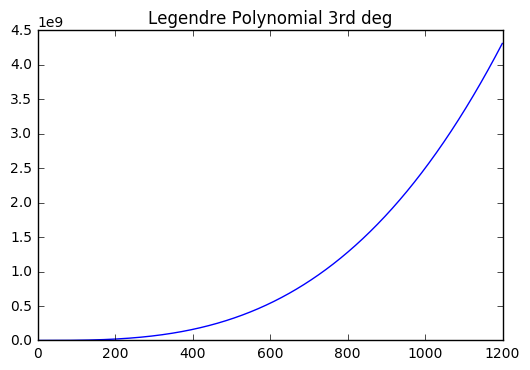

In [22]:
# ** a) create polynomial regressors **
nPoly = 1
x = np.arange(1200)
num_pol = range(nPoly)
y = np.ones((len(num_pol),len(x)))   
    
from numpy.polynomial.legendre import Legendre
leg = Legendre((1,1,1,1))
plt.figure()
plt.title('Legendre Polynomial 3rd deg')
y[0,:] = leg(x)
plt.plot(x,y[0])


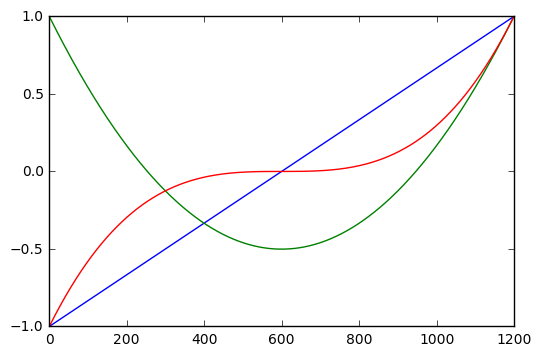

In [32]:
nPoly = 3
# Create polynomial regressors centered on 0 and bounded by -1 and 1
x = np.arange(1200)
num_pol = range(nPoly)
y = np.ones((len(num_pol),len(x)))


for i in num_pol:
    y[i,:] = (x - (np.max(x)/2)) **(i+1)
    y[i,:] = y[i,:] - np.mean(y[i,:])
    y[i,:] = y[i,:]/np.max(y[i,:])    
    plt.plot(x,y[i])
    
    
    
    


In [278]:
op.join(buildpath(subject,fmriRun))

'/media/paola/HCP/992774/MNINonLinear/Results/rfMRI_REST1_RL'

In [274]:
def Finn_preprocess(subject,fmriRun):
    fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.nii.gz')
    if not op.isfile(op.join(buildpath(subject,fmriRun),fmriRun+'_FinnPrepro.nii.gz')):
        # make WM, CSF, GM masks (if not already done)
        makeTissueMasks(subject,fmriRun,False)
        # get some info
        img = nib.load(fmriFile)
        hdr = img.header.structarr
        nTRs = long(hdr['dim'][4])
        # retrieve TR
        TR = hdr['pixdim'][4]
        # retrieve dimensions
        dim1 = long(hdr['dim'][1])
        dim2 = long(hdr['dim'][2])
        dim3 = long(hdr['dim'][3])
        ## DO PREPROCESSING:
        ## 1) Regress temporal drift from CSF and white matter (3rd order polynomial)
        print 'Step 1 (detrend WMCSF voxels, polynomial order 3)'
        # ** a) create polynomial regressors **
        nPoly = 3
        # Create polynomial regressors centered on 0 and bounded by -1 and 1
        x = np.arange(nTRs)
        num_pol = range(nPoly)
        y = np.ones((len(num_pol),len(x)))

        if(doPlot): 
            plt.figure()
            plt.title('Polynomial regressors')

        for i in num_pol:
            y[i,:] = (x - (np.max(x)/2)) **(i+1)
            y[i,:] = y[i,:] - np.mean(y[i,:])
            y[i,:] = y[i,:]/np.max(y[i,:])    
            if(doPlot): plt.plot(x,y[i])
        
        if(doPlot):
            plt.ylim((-1,1))
            plt.xlim((-0.1,nTRs+0.1))
            plt.show()
        
        # Print out text file for each polynomial to be used as a regressor
        for i in num_pol:
            np.savetxt(op.join(buildpath(subject,fmriRun),\
                        'poly_detrend_' + str(i+1) + '.txt'), y[i],fmt='%.2f')
            
        # ** b) use feat to regress them out
        # keep only WM/CSF voxels to speed things up
        WMCSFmaskFile = op.join(buildpath(subject,fmriRun),'WMCSFmask.nii.gz')
        if not op.isfile(op.join(buildpath(subject,fmriRun),fmriRun+'_WMCSF.nii.gz')):
            mymask1 = fsl.maths.ApplyMask(in_file=fmriFile, mask_file=WMCSFmaskFile, \
                                              out_file=op.join(buildpath(subject,fmriRun),fmriRun+'_WMCSF.nii.gz'))
            mymask1.run()
        
        # copy and alter detrendpoly3.fsf
        fsfFile = op.join(buildpath(subject,fmriRun), 'step1.fsf')
        copyfile(op.join(DATADIR,'detrendpoly3.fsf'), fsfFile)
        cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),'step1.feat'),fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
            .format(TR,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
            .format(nTRs,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
            .format(dim1*dim2*dim3*nTRs,fsfFile)
        call(cmd,shell=True) 
        cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),fmriRun+'_WMCSF.nii.gz'),fsfFile)
        call(cmd,shell=True)
        for i in num_pol:
            cmd = 'sed -i \'/set fmri(custom{}) /c\\set fmri(custom{}) "{}"\' {}'\
                .format(i+1,i+1,op.join(buildpath(subject,fmriRun),'poly_detrend_{}.txt'.format(i+1)),fsfFile)
            call(cmd,shell=True)
        
        # run feat
        step1_outFile = op.join(buildpath(subject,fmriRun),\
                               'step1.feat','stats','res4d.nii.gz')
        if not op.isfile(step1_outFile):
            myfeat1 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
            myfeat1.run()
        
        ## 2. Regress CSF/WM signal from gray matter voxels
        print 'Step 2 (regress WMCSF signal from GM)'
        # ** a) extract the WM/CSF data from the detrended volume
        WMCSFtxtFileout = op.join(buildpath(subject,fmriRun),\
                                  'step1.feat','stats','WMCSF.txt')
        if not op.isfile(WMCSFtxtFileout):
            meants1 = fsl.ImageMeants(in_file=step1_outFile, out_file=WMCSFtxtFileout, mask=WMCSFmaskFile)
            meants1.run()
        
        # ** b) keep only GM voxels to speed things up
        GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii.gz')
        if not op.isfile(op.join(buildpath(subject,fmriRun),fmriRun+'_GM.nii.gz')):
            mymask2 = fsl.maths.ApplyMask(in_file=fmriFile, mask_file=GMmaskFile, \
                                              out_file=op.join(buildpath(subject,fmriRun),fmriRun+'_GM.nii.gz'))
            mymask2.run()
        
        # ** c) use feat to regress it out **
        # copy and alter regressWMCSF.fsf
        fsfFile = op.join(buildpath(subject,fmriRun), 'step2.fsf')
        copyfile(op.join(DATADIR,'regressWMCSF.fsf'), fsfFile)
        cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),'step2.feat'),fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
            .format(TR,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
            .format(nTRs,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
            .format(dim1*dim2*dim3*nTRs,fsfFile)
        call(cmd,shell=True) 
        cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),fmriRun+'_GM.nii.gz'),fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(custom1) /c\\set fmri(custom1) "{}"\' {}'\
            .format(WMCSFtxtFileout,fsfFile)
        call(cmd,shell=True)
        
        # run feat
        step2_outFile = op.join(buildpath(subject,fmriRun),\
                               'step2.feat','stats','res4d.nii.gz')
        if not op.isfile(step2_outFile):
            myfeat2 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
            myfeat2.run()
        
        
        # add the results of steps 1 & 2 for input to the next stage
        step12_outFile = op.join(buildpath(subject,fmriRun),'step1+2.nii.gz')
        if not op.isfile(step12_outFile):
            myadd1 = fsl.maths.BinaryMaths(in_file=step1_outFile, operation='add',\
                                         operand_file=step2_outFile, out_file=step12_outFile)
            myadd1.run()
            
        ## 3. Regress motion parameters (found in the Movement_Regressors_dt_txt
        # file from HCP)    
        print 'Step 3 (regress 12 motion parameters from whole brain)'
        # ** a) load the detrended motion parameters
        motionFile = op.join(buildpath(subject,fmriRun),\
                            'Movement_Regressors_dt.txt')
        # this needs to be split into columns
        colNames = ['mmx','mmy','mmz','degx','degy','degz','dmmx','dmmy','dmmz','ddegx','ddegy','ddegz']
        df = pd.read_csv(motionFile,delim_whitespace=True,header=None)
        df.columns = colNames
        for iCol in range(len(colNames)):
            with open(motionFile.replace('.txt','_'+colNames[iCol]+'.txt'),'w') as tmp:
                df.to_csv(path_or_buf=tmp,sep='\n',columns=[colNames[iCol]],header=None,index=False)
                
        # ** b) use feat to regress them out **
        # copy and alter regressM12.fsf
        fsfFile = op.join(buildpath(subject,fmriRun), 'step3.fsf')
        copyfile(op.join(DATADIR,'regressM12.fsf'), fsfFile)
        cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),'step3.feat'),fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
            .format(TR,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
            .format(nTRs,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
            .format(dim1*dim2*dim3*nTRs,fsfFile)
        call(cmd,shell=True) 
        cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
            .format(step12_outFile,fsfFile)
        call(cmd,shell=True)
        for iCol in range(len(colNames)):
            cmd = 'sed -i \'/set fmri(custom{}) /c\\set fmri(custom{}) "{}"\' {}'\
                .format(iCol+1,iCol+1,motionFile.replace('.txt','_'+colNames[iCol]+'.txt'),fsfFile)
            call(cmd,shell=True)   
            
        # run feat
        step3_outFile = op.join(buildpath(subject,fmriRun),\
                               'step3.feat','stats','res4d.nii.gz')
        if not op.isfile(step3_outFile):
            myfeat3 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
            myfeat3.run()

        ## 4. Temporal smoothing with Gaussian kernel (sigma = 1 TR)
        print 'Step 4 (temporal smoothing with Gaussian kernel)'
        step4_outFile = op.join(buildpath(subject,fmriRun),'step4.nii.gz')
        if not op.isfile(step4_outFile):
            myfilter = fsl.maths.TemporalFilter(in_file=step3_outFile,highpass_sigma=0, lowpass_sigma=1,\
                                               out_file=step4_outFile)
            myfilter.run()
        ## 5. Regress temporal drift from gray matter (3rd order polynomial)
        print ('Step 5 (detrend gray matter voxels, polynomial order 3)')
        GMmaskfile = op.join(buildpath(subject,fmriRun),'GMmask.nii.gz')
        if not op.isfile(step4_outFile.replace('.nii.gz','_GM.nii.gz')):
            mymask3 = fsl.maths.ApplyMask(in_file=step4_outFile, mask_file=GMmaskFile, \
                                              out_file=step4_outFile.replace('.nii.gz','_GM.nii.gz'))
            mymask3.run()
        WMCSFmaskFile = op.join(buildpath(subject,fmriRun),'WMCSFmask.nii.gz') 
        if not op.isfile(step4_outFile.replace('.nii.gz','_WMCSF.nii.gz')):
            mymask4 = fsl.maths.ApplyMask(in_file=step4_outFile, mask_file=WMCSFmaskFile, \
                                              out_file=step4_outFile.replace('.nii.gz','_WMCSF.nii.gz'))
            mymask4.run()
        
        # ** b) use feat to regress them out **
        # copy and alter detrendpoly3.fsf
        fsfFile = op.join(buildpath(subject,fmriRun), 'step5.fsf')
        copyfile(op.join(DATADIR,'detrendpoly3.fsf'), fsfFile)
        cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),'step5.feat'),fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
            .format(TR,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
            .format(nTRs,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
            .format(dim1*dim2*dim3*nTRs,fsfFile)
        call(cmd,shell=True) 
        cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
            .format(step4_outFile.replace('.nii.gz','_GM.nii.gz'),fsfFile)
        call(cmd,shell=True)
        for i in num_pol:
            cmd = 'sed -i \'/set fmri(custom{}) /c\\set fmri(custom{}) "{}"\' {}'\
                .format(i+1,i+1,op.join(buildpath(subject,fmriRun),'poly_detrend_{}.txt'.format(i+1)),fsfFile)
            call(cmd,shell=True)
        
        # run feat
        step5tmp_outFile = op.join(buildpath(subject,fmriRun),\
                               'step5.feat','stats','res4d.nii.gz')
        if not op.isfile(step5tmp_outFile):
            myfeat4 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
            myfeat4.run()
            
        # add the WMCSF voxels back in for input to the next stage
        step5_outFile = op.join(buildpath(subject,fmriRun),'step5.nii.gz')
        if not op.isfile(step5_outFile):
            myadd2 = fsl.maths.BinaryMaths(in_file=step5tmp_outFile, operation='add',\
                operand_file=step4_outFile.replace('.nii.gz','_WMCSF.nii.gz'), out_file=step5_outFile)
            myadd2.run()
            
        ## 6. Regress global mean (mask includes all voxels in brain mask,
        # gray matter, white matter and CSF
        print 'Step 6 (GSR)'
        # ** a) extract the WM/CSF/GM data from detrended volume
        WMCSFGMmaskFile = op.join(buildpath(subject,fmriRun),'WMCSFGMmask.nii.gz')
        WMCSFGMtxtFileout = op.join(buildpath(subject,fmriRun),\
                                   'step5.feat','stats','WMCSFGM.txt')
        if not op.isfile(WMCSFGMtxtFileout):
            meants2 = fsl.ImageMeants(in_file=step5_outFile, out_file=WMCSFGMtxtFileout, mask=WMCSFGMmaskFile)
            meants2.run()
            
        # ** c) use feat to regress it out
        # copy and alter regressWMCSF.fsf
        fsfFile = op.join(buildpath(subject,fmriRun), 'step6.fsf')
        copyfile(op.join(DATADIR,'regressWMCSF.fsf'), fsfFile)
        cmd = 'sed -i \'/set fmri(outputdir) /c\\set fmri(outputdir) "{}"\' {}'\
            .format(op.join(buildpath(subject,fmriRun),'step6.feat'),fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(tr) /c\\set fmri(tr) {:.3f}\' {}'\
            .format(TR,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(npts) /c\\set fmri(npts) {}\' {}'\
            .format(nTRs,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(totalVoxels) /c\\set fmri(totalVoxels) {}\' {}'\
            .format(dim1*dim2*dim3*nTRs,fsfFile)
        call(cmd,shell=True) 
        cmd = 'sed -i \'/set feat_files(1) /c\\set feat_files(1) "{}"\' {}'\
            .format(step5_outFile,fsfFile)
        call(cmd,shell=True)
        cmd = 'sed -i \'/set fmri(custom1) /c\\set fmri(custom1) "{}"\' {}'\
            .format(WMCSFGMtxtFileout,fsfFile)
        call(cmd,shell=True)
        
        # run feat
        step6_outFile = op.join(buildpath(subject,fmriRun),\
                               'step6.feat','stats','res4d.nii.gz')
        if not op.isfile(step6_outFile):
            myfeat5 = fsl.FEAT(fsf_file=fsfFile,terminal_output='none')
            myfeat5.run()
            
        ## We're done! Copy the resulting file
        copyfile(step6_outFile,op.join(buildpath(subject,fmriRun),\
                                      fmriRun+'_FinnPrepro.nii.gz'))
        
            

In [ ]:
Finn_preprocess(subject,fmriRun)

In [276]:
print fmriFile
op.basename(op.dirname(op.dirname(op.dirname(op.dirname(fmriFile)))))

/media/paola/HCP/992774/MNINonLinear/Results/rfMRI_REST1_RL/rfMRI_REST1_RL_hp2000_clean.nii.gz


'992774'

In [142]:
def Finn_loadandpreprocess(subject, fmriRun, parcellation, overwrite):
    fmriFile = op.join(buildpath(subject,fmriRun),fmriRun+suffix+'.nii.gz')
    ResultsDir = op.join(DATADIR,'Results')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,'Finn')
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    ResultsDir = op.join(ResultsDir,parcellation)
    if not op.isdir(ResultsDir): mkdir(ResultsDir)
    if parcellation=='shenetal_neuroimage2013':
        uniqueParcels = range(268)
    else:
        print "Invalid parcellation code"
        return
    
    for iParcel in uniqueParcels:
        parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.nii.gz'.format(iParcel+1))
        if not op.isfile(parcelMaskFile):
            print 'Making a binary volume mask for each parcel'
            mymaths = fsl.maths.MathsCommand(in_file=op.join(PARCELDIR, parcellation,'fconn_atlas_150_2mm.nii'),\
                out_file=parcelMaskFile, args='-thr {:.1f} -uthr {:.1f}'.format(iParcel+1-0.1, iParcel+1+0.1)) 
            mymaths.run()
    if not op.isfile(fmriFile):
        print fmriFile, 'does not exist'
        return
    
    tsDir = op.join(buildpath(subject,fmriRun),parcellation)
    if not op.isdir(tsDir): mkdir(tsDir)
    alltsFile = op.join(ResultsDir,subject+'_'+fmriRun+'.txt')
    alltsGMFile = op.join(ResultsDir,subject+'_'+fmriRun+'_GM.txt')
    if not (op.isfile(alltsFile)) or not (op.isfile(alltsGMFile)) or overwrite:
        fmriFile_prepro = op.join(buildpath(subject,fmriRun), fmriRun+'_FinnPrepro.nii.gz')
        # make WM, CSF, GM masks
        if not op.isfile(op.join(buildpath(subject,fmriRun), fmriRun+'GMmask.nii.gz')):
            makeTissueMasks(subject,fmriRun,overwrite)
        
        # perform preprocessing (if not already done)
        if not op.isfile(fmriFile_prepro):
            Finn_preprocess(fmriFile)
            
        # calculate signal in each of the nodes by averaging across all voxels in node
        print 'Extracting mean data from',str(len(uniqueParcels)),'parcels for ',fmriFile_prepro
        subjectParcelDir = op.join(DATADIR,subject,'MNINonLinear','Results','parcellations')
        if not op.isdir(subjectParcelDir): mkdir(subjectParcelDir)
        if not op.isdir(op.join(subjectParcelDir,parcellation)): mkdir(op.join(subjectParcelDir,parcellation))
        
        for iParcel in uniqueParcels:
            parcelMaskFile = op.join(PARCELDIR,parcellation,'parcel{:03d}.nii.gz'.format(iParcel+1))
            GMmaskFile = op.join(buildpath(subject,fmriRun),'GMmask.nii.gz')
            # intersect GM & parcel
            parcelGMMaskFile = op.join(subjectParcelDir,parcellation,'GMparcel{:03d}.nii.gz'.format(iParcel+1))
            mymaths = fsl.maths.MathsCommand(in_file=parcelMaskFile,\
                out_file=parcelGMMaskFile, args='-mul '+GMmaskFile)
            mymaths.run()
            tsFile = op.join(tsDir,'parcel{:03d}.txt'.format(iParcel+1))
            if not op.isfile(tsFile):
                # simply average the voxels within the mask
                meants1 = fsl.ImageMeants(in_file=fmriFile_prepro, out_file=tsFile, mask=parcelMaskFile)
                meants1.run()
                
            tsFile = op.join(tsDir,'GMparcel{:03d}.txt'.format(iParcel+1))    
            if not op.isfile(tsFile):
                # simply average the voxels within the mask
                meants2 = fsl.ImageMeants(in_file=fmriFile_prepro, out_file=tsFile, mask=parcelGMMaskFile)
                meants2.run()
                
        # concatenate all ts
        print 'Concatenating data'
        cmd = 'paste '+op.join(tsDir,'parcel*.txt')+' > '+alltsFile
        call(cmd, shell=True)
        cmd = 'paste '+op.join(tsDir,'GMparcel*.txt')+' > '+alltsGMFile
        call(cmd, shell=True)         
        

In [ ]:
Finn_loadandpreprocess(subject,fmriRun, parcellation, overwrite)

### Get subjects

In [16]:
df = pd.read_csv(behavFile)

# select subjects according to release
if release == 'Q2':
    ind = (df['Release'] == 'Q2') \
    | (df['Release'] == 'Q1')
elif release == 'S500':
    ind = (df['Release'] != 'Q2') & (df['Release'] != 'Q1')
else:
    sys.exit("Invalid release code")
    
# select subjects that have completed all fMRI
ind = ind & ((df['fMRI_WM_Compl']== True) & (df['fMRI_Mot_Compl']==True) \
        & (df['fMRI_Lang_Compl']==True) & (df['fMRI_Emo_Compl']==True) \
        & (df['RS-fMRI_Count']==4))
                
df = df[ind]  

# check if either of the two subjects recommended for exclusion by HCP are still present
df = df[~df['Subject'].isin(['209733','528446'])]
df.index = range(df.shape[0])
print 'Selected', str(df.shape[0]), 'from the release',release
print 'Number of males is:', df[df['Gender']=='M'].shape[0]
tmpAgeRanges = sorted(df['Age'].unique())
print 'Age range is', tmpAgeRanges[0].split('-')[0], '-', tmpAgeRanges[-1].split('-')[1]

# list of all selected subjects
subjects = df['Subject']
# pull their IQ, Age, Gender
age = df['Age']
gender = df['Gender']
score = df[outScore]

Selected 125 from the release Q2
Number of males is: 40
Age range is 22 - 35


### Score distribution

array([ 3,  7, 10, 10, 15, 17, 19, 27, 17])

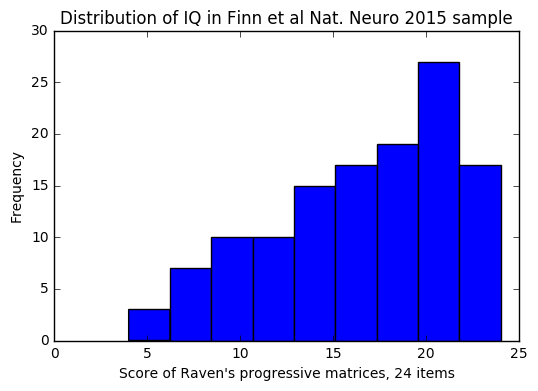

In [117]:
plot_hist(score, 'Distribution of IQ in Finn et al Nat. Neuro 2015 sample', \
          'Score of Raven\'s progressive matrices, 24 items')

### Exclusion of high-motion subjects
Further exclude subjects with >0.14 frame-to-frame head motion estimate averged across both rest runs (arbitrary threshold as in Finn et al 2015)

In [ ]:
ResultsDir = op.join(DATADIR, 'Testing','Results')
if not op.isdir(ResultsDir): makedirs(ResultsDir)
#ResultsDir = op.join(DATADIR,'Results')
#if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, 'Finn')
if not op.isdir(ResultsDir): mkdir(ResultsDir)
ResultsDir = op.join(ResultsDir, parcellation)
if not op.isdir(ResultsDir): mkdir(ResultsDir)

PEdirs = ['LR', 'RL']
RelRMSMean = np.zeros([len(subjects), 2])
excludeSub = list()

for iSub in range(len(subjects)):
    subject = str(subjects[iSub])
    RelRMSMeanFile = op.join(buildpath(subject, thisRun+'_zz'), 'Movement_RelativeRMS_mean.txt')
    fLR = RelRMSMeanFile.replace('zz','LR');
    fRL = RelRMSMeanFile.replace('zz','RL');
    
    if op.isfile(fLR) & op.isfile(fRL):
        with open(fLR,'r') as tmp:
            RelRMSMean[iSub,0] = float(tmp.read())
        with open(fRL,'r') as tmp:
            RelRMSMean[iSub,1] = float(tmp.read())
        print '{} {:.3f} {:.3f}'.format(subjects[iSub], RelRMSMean[iSub,0], RelRMSMean[iSub,1])
        if np.mean(RelRMSMean[iSub,:]) > 0.14:
            print subjects[iSub], ': too much motion, exclude'
            excludeSub.append(iSub)
            continue
     
    for iPEdir in range(len(PEdirs)):
        PEdir=PEdirs[iPEdir]
        fmriRun = thisRun+'_'+PEdir 
        fmriFile = op.join(buildpath(subject,fmriRun),
                           fmriRun+suffix+'.nii.gz')
        if not op.isfile(fmriFile):
            print str(subjects[iSub]), 'missing', fmriFile, ', exclude'
            excludeSub.append(iSub)
            continue
        
        if not (op.isfile(op.join(ResultsDir, str(subjects[iSub])+'_'+thisRun+'_'+PEdir+'.txt'))) \
        or not (op.isfile(op.join(ResultsDir, str(subjects[iSub])+'_'+thisRun+'_'+PEdir+'._GM.txt'))) \
        or overwrite:
            print 'load and preprocess'
            Finn_loadandpreprocess(subject, fmriRun, parcellation, overwrite)
        else:
            print subject[iSub], ' : ', PEdir, 'results already computed; skipping'

indkeep = np.setdiff1d(range(len(subjects)),excludeSub, assume_unique=True)

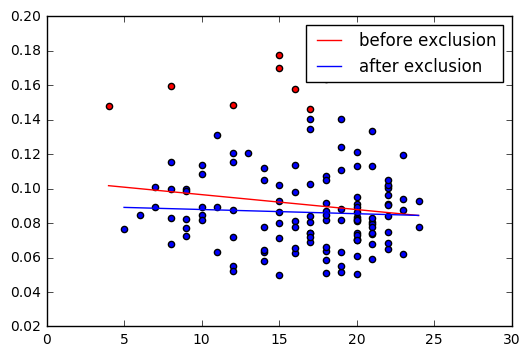

With all subjects: corr(IQ,motion) = -0.154 (p = 0.087)
After discarding high movers: corr(IQ,motion) = -0.056 (p = 0.552)


In [214]:
plt.scatter(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),c='b')
plt.scatter(score[excludeSub],np.mean(RelRMSMean[excludeSub,:],axis=1),c='r')
# fit a curve to the data using a least squares 1st order polynomial fit
z1 = np.polyfit(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1),1)
z2 = np.polyfit(score,np.mean(RelRMSMean,axis=1),1)
p1 = np.poly1d(z1)
p2 = np.poly1d(z2)                
fit1 = p1(score[indkeep])
fit2 = p2(score)
# get the coordinates for the fit curve
c1_x = [np.min(score[indkeep]),np.max(score[indkeep])]
c1_y = p1(c1_x)
c2_x = [np.min(score),np.max(score)]
c2_y = p2(c2_x)
# plot line of best fit
plt.plot(c2_x,c2_y,'r-',label='before exclusion')
plt.plot(c1_x,c1_y,'b-',label='after exclusion')
plt.legend(loc=0)
plt.show()
rho1,p1 = stats.pearsonr(score[indkeep],np.mean(RelRMSMean[indkeep,:],axis=1))
rho2,p2 = stats.pearsonr(score,np.mean(RelRMSMean,axis=1))                         
print 'With all subjects: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho2,p2)
print 'After discarding high movers: corr(IQ,motion) = {:.3f} (p = {:.3f})'.format(rho1,p1)

### Correlation matrices

Correlate all pairs of node timecourses, resulting in 268x268 matrix of r-values

Apply Fisher transform to obtain 268x268 matrix of z-scores. The LR and RL runs are never concatenated. Rather, we run the above pipeline on each run separately and average the two resulting matrices of z-scores.

In [93]:
excludeSub

[8, 15, 34, 37, 51, 72, 104, 122]

In [101]:
# Whole Parcels
corrmats = np.zeros([268,268,len(indkeep)])
scores = np.zeros([len(indkeep)])
index = 0
for iSub in range(len(subjects)):
    if iSub not in excludeSub:
        PEdir=PEdirs[iPEdir] 
        tsFile_LR=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_LR.txt')
        tsFile_RL=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_RL.txt')
        ts_LR = np.loadtxt(tsFile_LR)
        ts_RL = np.loadtxt(tsFile_RL)
        # Fisher z transform of correlation coefficients
        corrMat_LR = np.arctanh(np.corrcoef(ts_LR,rowvar=0))
        corrMat_RL = np.arctanh(np.corrcoef(ts_RL,rowvar=0))
        np.fill_diagonal(corrMat_LR,1)
        np.fill_diagonal(corrMat_RL,1)
        corrmats[:,:,index] = (corrMat_LR + corrMat_RL)/2
        scores[index] = score[iSub]
        
results = {}
results[outMat] = corrmats
results[outScore] = scores
sio.savemat(op.join(ResultsDir,'{}_HCP_{}.mat'.format(thisRun,release)),results)

# GM Parcels        
index = 0
for iSub in range(len(subjects)):
    if iSub not in excludeSub:
        PEdir=PEdirs[iPEdir] 
        tsFile_LR=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_LR_GM.txt')
        tsFile_RL=op.join(ResultsDir,str(subjects[iSub])+'_'+thisRun+'_RL_GM.txt')
        ts_LR = np.loadtxt(tsFile_LR)
        ts_RL = np.loadtxt(tsFile_RL)
        # Fisher z transform of correlation coefficients
        corrMat_LR = np.arctanh(np.corrcoef(ts_LR,rowvar=0))
        corrMat_RL = np.arctanh(np.corrcoef(ts_RL,rowvar=0))
        np.fill_diagonal(corrMat_LR,1)
        np.fill_diagonal(corrMat_RL,1)
        corrmats[:,:,index] = (corrMat_LR + corrMat_RL)/2
        scores[index] = score[iSub]
        
results = {}
results[outMat] = corrmats
results[outScore] = scores
sio.savemat(op.join(ResultsDir,'{}_HCP_{}_GM.mat'.format(thisRun,release)),results)      

### Behavioral prediction

In [161]:
toLoad = 'rfMRI_REST1_HCP_Q2'
data = sio.loadmat(toLoad)

## INPUTS
all_mats = data['rest_1_mat']
all_behav = data['PMAT24_A_CR']

# threshold for feature selection
thresh = 0.01

no_sub = all_mats.shape[2]
no_node = all_mats.shape[0]

behav_pred_pos = np.zeros([no_sub,1])
behav_pred_neg = np.zeros([no_sub,1])

In [211]:
train_index = range(125)
# leave out subject from matrices and behaviour
train_mats = all_mats[:,:,train_index]
train_vcts = np.reshape(train_mats, [-1,train_mats.shape[2]])
train_behav = all_behav[train_index]
vcts_len = train_vcts.shape[0]
# correlate all edges with behavior
pears = [stats.pearsonr(train_vcts[i,train_index],np.squeeze(train_behav[train_index])) 
         for i in range(vcts_len)]
# set threshold and define masks
idx_filtered_pos = np.array([idx for idx in range(vcts_len) 
                             if pears[idx][1]<thresh and pears[idx][0]>0])
idx_filtered_neg = np.array([idx for idx in range(vcts_len) 
                             if pears[idx][1]<thresh and pears[idx][0]<0])
filtered_pos = train_vcts[np.ix_(idx_filtered_pos,train_index)]
filtered_neg = train_vcts[np.ix_(idx_filtered_neg,train_index)]
# get sum of all edges in TRAIN subs (divide by 2 to control
# for the fact that matrices are symmetric)
train_sumpos = filtered_pos.sum(axis=0)/2 
train_sumneg = filtered_neg.sum(axis=0)/2
# build model on TRAIN subs
z_pos = np.polyfit(train_sumpos,np.squeeze(train_behav),1)
p = np.poly1d(z_pos)
fit_pos = p(train_sumpos)
z_neg = np.polyfit(train_sumneg,np.squeeze(train_behav),1)
p = np.poly1d(z_neg)
fit_neg = p(train_sumneg)
# run model on TEST sub
test_mats = all_mats[:,:,test_index]
test_vec = np.reshape(test_mats, [-1,test_mats.shape[2]])
test_sumpos = test_vec[idx_filtered_pos].sum()/2
test_sumneg = test_vec[idx_filtered_neg].sum()/2
behav_pred_pos[test_index] = z_pos[0] * test_sumpos + z_pos[1]
behav_pred_neg[test_index] = z_neg[0] * test_sumneg + z_neg[1]

# compare predicted and observed score
R_pos,P_pos = stats.pearsonr(behav_pred_pos,np.squeeze(all_behav))
R_neg,P_neg = stats.pearsonr(behav_pred_neg,np.squeeze(all_behav))

In [222]:
train_vcts.shape

(71824, 124)

In [234]:
loo = cross_validation.LeaveOneOut(no_sub)
lr = linear_model.LinearRegression()
predictions_pos = np.zeros([no_sub,1])
predictions_neg = np.zeros([no_sub,1])

for train_index, test_index in loo:
    # leave out subject from matrices and behaviour
    train_mats = all_mats[:,:,train_index]
    train_vcts = np.reshape(train_mats, [-1,train_mats.shape[2]])
    train_behav = all_behav[train_index]
    vcts_len = train_vcts.shape[0]
    # correlate all edges with behavior
    pears = [stats.pearsonr(train_vcts[i,:],np.squeeze(train_behav)) 
             for i in range(vcts_len)]
    # set threshold and define masks
    idx_filtered_pos = np.array([idx for idx in range(vcts_len) 
                                 if pears[idx][1]<thresh and pears[idx][0]>0])
    idx_filtered_neg = np.array([idx for idx in range(vcts_len) 
                                 if pears[idx][1]<thresh and pears[idx][0]<0])
    filtered_pos = train_vcts[idx_filtered_pos,:]
    filtered_neg = train_vcts[idx_filtered_neg,:]
    # get sum of all edges in TRAIN subs (divide by 2 to control
    # for the fact that matrices are symmetric)
    train_sumpos = filtered_pos.sum(axis=0)/2 
    train_sumneg = filtered_neg.sum(axis=0)/2
    # build model on TRAIN subs
    z_pos = np.polyfit(train_sumpos,np.squeeze(train_behav),1)
    p = np.poly1d(z_pos)
    fit_pos = p(train_sumpos)
    z_neg = np.polyfit(train_sumneg,np.squeeze(train_behav),1)
    p = np.poly1d(z_neg)
    fit_neg = p(train_sumneg)
    # run model on TEST sub
    test_mats = all_mats[:,:,test_index]
    test_vec = np.reshape(test_mats, [-1,test_mats.shape[2]])
    test_sumpos = test_vec[idx_filtered_pos].sum()/2
    test_sumneg = test_vec[idx_filtered_neg].sum()/2
    behav_pred_pos[test_index] = z_pos[0] * test_sumpos + z_pos[1]
    behav_pred_neg[test_index] = z_neg[0] * test_sumneg + z_neg[1]
    lr_pos = lr.fit(train_sumpos.reshape(-1,1),train_behav)
    predictions_pos[test_index] = lr_pos.predict(test_sumpos)
    lr_neg = lr.fit(train_sumneg.reshape(-1,1),train_behav)
    predictions_neg[test_index] = lr_neg.predict(test_sumneg) 
    
# compare predicted and observed score
R_pos,P_pos = stats.pearsonr(behav_pred_pos,np.squeeze(all_behav))
R_neg,P_neg = stats.pearsonr(behav_pred_neg,np.squeeze(all_behav))    

In [ ]:
loo = cross_validation.LeaveOneOut(n_subj)
lr = linear_model.LinearRegression()
errors_pos = np.zeros([n_subj,1])
errors_neg = np.zeros([n_subj,1])
predictions_pos = np.zeros([n_subj,1])
predictions_neg = np.zeros([n_subj,1])

def regress(p,score,edges):
    i=0
    f = FloatProgress(min=0, max=n_subj)
    display(f)
    for train_index, test_index in loo:
        pears = [stats.pearsonr(edges[train_index,i],gF[train_index]) for i in range(0,n_edges)]
        # select edges (positively and negatively) correlated with gF with threshold p
        idx_filtered_pos = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]>0])
        idx_filtered_neg = np.array([idx for idx in range(1,n_edges) if pears[idx][1]<p and pears[idx][0]<0])
        filtered_pos = edges[np.ix_(train_index,idx_filtered_pos)]
        filtered_neg = edges[np.ix_(train_index,idx_filtered_neg)]
        # compute network statistic for each subject in training
        strength_pos = filtered_pos.sum(axis=1) 
        strength_neg = filtered_neg.sum(axis=1)
        # compute network statistic for test subject
        str_pos_test = edges[test_index,idx_filtered_pos].sum()
        str_neg_test = edges[test_index,idx_filtered_neg].sum()
        # regression
        lr_pos = lr.fit(strength_pos.reshape(-1,1),gF[train_index])
        predictions_pos[i] = lr_pos.predict(str_pos_test)
        lr_neg = lr.fit(strength_neg.reshape(-1,1),gF[train_index])
        predictions_neg[i] = lr_neg.predict(str_neg_test) 
        errors_pos[i] = abs(predictions_pos[i]-gF[test_index])
        errors_neg[i] = abs(predictions_neg[i]-gF[test_index])
        i=i+1
        f.value += 1
        
#interact(regress, p=(0.01,0.1,0.01),score=fixed(gF), edges=fixed(edges),continuous_update=False)
p=0.01
regress(p,gF,edges)

0.120557761577


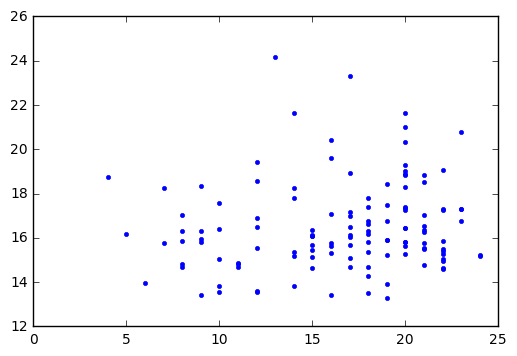

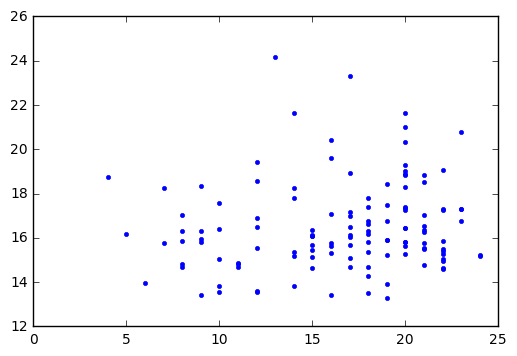

In [235]:
plt.figure()
plt.plot(all_behav,behav_pred_pos,'b.')
plt.figure()
plt.plot(all_behav,predictions_pos,'b.')
print(R_pos)